<a href="https://colab.research.google.com/github/jprussoibanez/plant-seedlings-classification/blob/master/results/resnet-v2/fine-tuning-resnet-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORTANT: Change BASE_DATASET_FOLDER with the root dataset folder with the images.

In [0]:
#@title
import sys
# Chack environment: google colab or kaggle/local
IN_GOOGLE_COLAB = 'google.colab' in sys.modules

In [0]:
#@title
if IN_GOOGLE_COLAB:    
    from google.colab import drive
    drive.mount('/content/drive')

    # Change BASE_DATASET_FOLDER according to folder with dataset
    BASE_DATASET_FOLDER = "/content/drive/My Drive/Colab Notebooks/Tryolabs-CV-Interview/data/"

In [0]:
#@title
if not IN_GOOGLE_COLAB:
    # Assume Kaggle or local environment
    # Change BASE_DATASET_FOLDER according to folder with dataset
    BASE_DATASET_FOLDER = "../input/plant-seedlings-classification"

# The project
The problem to analyze is the [Kaggle plant seedlings classification](https://www.kaggle.com/c/plant-seedlings-classification).

##  Competition goal
The goal is to differentiate a weed from a crop seedling in order to perform site-specific weed control.

## Dataset
The [database of images](https://arxiv.org/abs/1711.05458) has approximately 960 unique plants belonging to 12 species at several growth stages. It comprises annotated RGB images with a physical resolution of roughly 10 pixels per mm.

## Kernel structure
The following is a summary of the kernel main structure.

### 1. Kagglers challenges and discussions
- Review other kagglers kernels to better understand the competition challenges.
- Review the competition discussion forum for interesting conversation threads.
- Generate insights from the information gathering.

For further information please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/kagglers_discussions.md).

### 2. Libraries and settings
- This section has available settings to configure the model and its training parameters.

For further information please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/settings.md).

### 3. Data analysis
- Data exploration and descriptive analysis to determine dataset shape and distribution.
- Use of t-SNE to reduce dimensionality for data visualization.

### 4. Pre-processing
- Class weights calculation to balance the dataset distribution.
- Image segmentation to mask image background.
- Data augmentation to increase the images dataset.

### 5. Processing
- Use of transfer learning with different pre-trained models like Resnet50 and InceptionV3. Other pre-trained models can be easily added.
- Use of custom CNN with multiple layers.
- FNN as the last layer classifier.

### 6. Generate prediction file
- Generate prediction file with Kaggle competition format.

# 1. Kagglers challenges and discussions
The first step is to review the discussion forum for this competition to better discover the challenges and approaches in solving the problem.

For a detailed discussion please refer [here](https://github.com/jprussoibanez/plant-seedlings-classification/blob/master/docs/kagglers_discussions.md).


# 2. Libraries and settings

## 2.1 Libraries

This are the main libraries for coding the kernel:
1. [tensorflow](https://www.tensorflow.org/) with [keras](https://keras.io/) for managing the deep learning models. Using latest tensorflow 2.0 and tensorflow keras on google colab.
2. [sckilit-learn](https://scikit-learn.org/), [numpy](https://numpy.org/), [pandas](https://pandas.pydata.org/) with [seaborn](https://seaborn.pydata.org/) for data manipulation, analysis and visualization.
3. [TQDM](https://github.com/tqdm/tqdm) for progress bar visualization on processing.
4. [opencv](https://pypi.org/project/opencv-python/) for image processing.

In [0]:
#@title
if IN_GOOGLE_COLAB:
  !pip install scikit-optimize
  %tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import pandas as pd

# Keras
from tensorflow.keras.applications import vgg16, vgg19, inception_v3, resnet_v2, xception, resnet, inception_resnet_v2, nasnet, mobilenet_v2
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, Input, Activation, BatchNormalization, GlobalMaxPooling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

import os

# Helpers
from tqdm import tqdm
from enum import Enum

# Image processing
import cv2

# Image plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import xgboost as xgb
from sklearn.svm import SVC
import lightgbm as lgb

## 2.2 Global variables

This are the global variables use to setup the configuration for the models.

In [0]:
#@title
class ConvolutionalModel(Enum):
    CUSTOM_CNN = 1    
    RESNET_V2 = 2     
    INCEPTION_V3 = 3  
    XCEPTION = 4      
    INCEPTION_RESNET_V2 = 4 
    VGG16 = 5,
    VGG19 = 6,
    MOBILE_NET_V2 = 7,
    NASNET_MOBILE = 8

class ClassifierModel(Enum):
    FCN = 1    
    XGBoost = 2     
    SVM = 3
    LIGHT_GBM = 4

In [0]:
#@title
# Global settings
TRAIN_DATASET_FOLDER = os.path.join(BASE_DATASET_FOLDER, "train")
TEST_DATASET_FOLDER = os.path.join(BASE_DATASET_FOLDER, "test")
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

TSNE_VISUALIZATION = False

# Data augmentation settings
rotation_range = 180      
zoom_range = 0.5      
width_shift_range = 0.5  
height_shift_range = 0.5 
horizontal_flip = True   
vertical_flip = True

# Training settings
batch_size = 32
epochs = 500
patience = 10

# Choose convolutional base and classifier model to train
CONVOLUTIONAL_MODEL = ConvolutionalModel.RESNET_V2
CLASSIFIER_MODEL = ClassifierModel.FCN

# 3. Data analysis

The first and the most important task in solving a problem with Machine Learning is to analyze the dataset before proceeding with any algorithms. This is important in order to understand the complexity of the dataset which will eventually help in designing the algorithm.

## 3.1 Load data and images

The first step is to load the images and data from the datasets through panda and dataframes.

In [0]:
#@title
def get_species_groups():
    """ 
    Get the species group from the folders' name on the dataset. 
  
    @Returns: 
        array: Array of species groups to train.
    """
    return [
      'Black-grass',
      'Charlock',
      'Cleavers',
      'Common Chickweed',
      'Common wheat',
      'Fat Hen',
      'Loose Silky-bent',
      'Maize',
      'Scentless Mayweed',
      'Shepherds Purse',
      'Small-flowered Cranesbill',
      'Sugar beet'
    ]

def read_train_data(species_groups):
    """ 
    Read the train species data from the datasets folder. 
  
    @Parameters:
        species_groups (array): Array of species groups to train.
  
    @Returns: 
        dataframe: Dataframe with the filepath, filename and species group category for each species image.
    """
    train = []
    for _, species in tqdm(enumerate(species_groups), total=len(species_groups)):
        for file in os.listdir(os.path.join(TRAIN_DATASET_FOLDER, species)):
            train.append([f'{TRAIN_DATASET_FOLDER}/{species}/{file}', file, species])
    
    train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species'])
    
    return train_df

def read_image(image_file_path, image_width, image_height):
    """ 
    Read and transform image according to widht, height and channels.
  
    @Parameters:
        image_file_path(string): Image file path to read.
        image_width (int): Image width to resize.
        image_height (int): Image height to resize.
  
    @Returns: 
        array: Array of loaded images resized to image_width and image_height.
    """
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_width, image_height))
    
    return image

def load_images(filepaths, image_width, image_height, preprocess_function = lambda x: x):
    images =[]
    for filepath in tqdm(filepaths, total=len(filepaths)):
      images.append(preprocess_function(read_image(filepath, image_width, image_height)))

    return images
    
def load_species_images(species_data, image_width, image_height, preprocess_function = lambda x: x):
    """ 
    Load images to input features on neural network model and do one hot encode for labels.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        image_width (int): Image width to resize.
        image_height (int): Image height to resize.
       
    @Returns: 
        species_X (array): Array of images on the data.
        species_Y (array): One hot encode for labels.
    """ 
    species_X = load_images(species_data['filepath'],image_width, image_height, preprocess_function)
    species_Y = pd.get_dummies(species_data['species'], drop_first = False)
    
    return np.stack(species_X), species_Y

def show_grid_multiple_sample(species_data, species_groups):
    """ 
    Plot sample images from each species group.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        species_groups (array): Array with species group.
       
    @Returns: None
    Plots grid with number_of_samples images with image_size for each species_group
    """
    number_of_samples = 8
    image_size = 100
    
    number_of_species = len(species_groups) 
    fig, axes = plt.subplots(nrows = number_of_species, ncols = number_of_samples + 1, figsize = (20, 28), gridspec_kw = {'wspace': 0.05, 'hspace': 0})
 
    for species_id, species in enumerate(species_groups):
        samples_species_filepath = species_data[species_data['species'] == species]['filepath'].sample(number_of_samples)
        ax = axes[species_id, 0]
        ax.axis('off')
        ax.text(0.5, 0.5, species, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, transform = ax.transAxes)
        for sample_id, sample_species_filepath in enumerate(samples_species_filepath):
            image = read_image(sample_species_filepath, image_size, image_size)
            ax = axes[species_id, sample_id + 1]
            ax.axis('off')
            ax.imshow(image)
            
    plt.show()

def show_grid_one_sample(species_data, species_groups):
    """ 
    Plot one sample image from each species group.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
        species_groups (array): Array with species group.
       
    @Returns: None
    Plots one sample image with image_size for each species_group
    """
    image_size = 100
    number_of_species = len(species_groups)
    
    fig, axes = plt.subplots(nrows = 2, ncols = int(number_of_species / 2), figsize = (20, 8), gridspec_kw = {'wspace': 0.05, 'hspace': 0.05})
    axes = axes.flatten()
    
    for group_id, (group_name, group) in enumerate(species_data.groupby('species')):
        image = read_image(group.sample(1).iloc[0]['filepath'], image_size, image_size)
        axes[group_id].axis('off')
        axes[group_id].set_title(group_name)
        axes[group_id].imshow(image)
            
    plt.show()
    
def show_species_distribution(species_data):
    """ 
    Plot species distribution.
  
    @Parameters:
        species_data (dataframe): Dataframe with the filepath, filename and species group category for each species image to load.
       
    @Returns: None
    Plots species distribution on an histogram and pie chart.
    """
    species_groups = species_data['species'].unique()
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    colors_palette = sns.husl_palette(len(species_groups), h = 0.01, l = 0.6, s = .2)
    explode_chart = np.full(len(species_groups), 0.1)
    
    species_data.groupby('species').size().plot.bar(
        subplots = True, ax = axes[0], stacked = True, title = 'Species distribution', label = "", color = colors_palette
    )
     
    species_data['species'].value_counts().plot.pie(
        subplots = True, ax = axes[1], autopct = '%.2f', title = 'Species distribution', label = "", colors = colors_palette, explode = explode_chart
    )
    
    plt.show()
    
class TSNE_dimension(Enum):
    TWO = 1
    THREE = 2
    
def apply_PCA(images, n_components = 100):
    pca = PCA(n_components = n_components)
    pca_result = pca.fit_transform(images)
    
    return pca_result

def apply_TSNE(images, n_components = 2, perplexity = 100):
    tsne = TSNE(n_components = n_components, perplexity = perplexity)
    tsne_result = tsne.fit_transform(images)
    
    return tsne_result

def plot_TSNE_with_PCA(images, image_labels, dimension = TSNE_dimension.TWO):
    pca_results = apply_PCA(images)
    n_components = (2 if dimension == TSNE_dimension.TWO else 3)
    tsne_result = apply_TSNE(pca_results, n_components)
    plot_TSNE_results(tsne_result, image_labels, dimension = TSNE_dimension.TWO)

def plot_TSNE_results(tsne_result, image_labels, dimension = TSNE_dimension.TWO):
    df = pd.DataFrame(tsne_result).assign(label = image_labels)
    plt.figure(figsize=(10,10))
    if dimension == TSNE_dimension.TWO:
        sns.scatterplot(x = 0, y = 1, hue = 'label', data = df);
    else:
        fig = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'label')
        fig.show();

### 3.1.1 Load data

Load data from the datasets image folders.

In [0]:
#@title
species_groups = get_species_groups()
print(f"This are the groups to be loaded and trained: {species_groups}")

This are the groups to be loaded and trained: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [0]:
#@title
all_train_df = read_train_data(species_groups)
all_train_df.sample(4)

100%|██████████| 12/12 [00:00<00:00, 110.87it/s]


filepath           file  \
676   ../input/plant-seedlings-classification/train/...  0ac327873.png   
2006  ../input/plant-seedlings-classification/train/...  946b48f62.png   
4283  ../input/plant-seedlings-classification/train/...  f1196e55f.png   
2656  ../input/plant-seedlings-classification/train/...  c6f54e816.png   

                        species  
676                    Cleavers  
2006                    Fat Hen  
4283  Small-flowered Cranesbill  
2656           Loose Silky-bent

### 3.1.2 Descriptive analysis

The descriptive analysis has the following steps:
1. Visualize sample images by species group.
2. Analyze species group distribution.
3. Apply dimensionality reduction through PCA & t-SNE.

#### 3.1.2.1 Sample images by species group

The sample visualization shows the difficulty to distinguish between different weeds species groups even for a human eye.

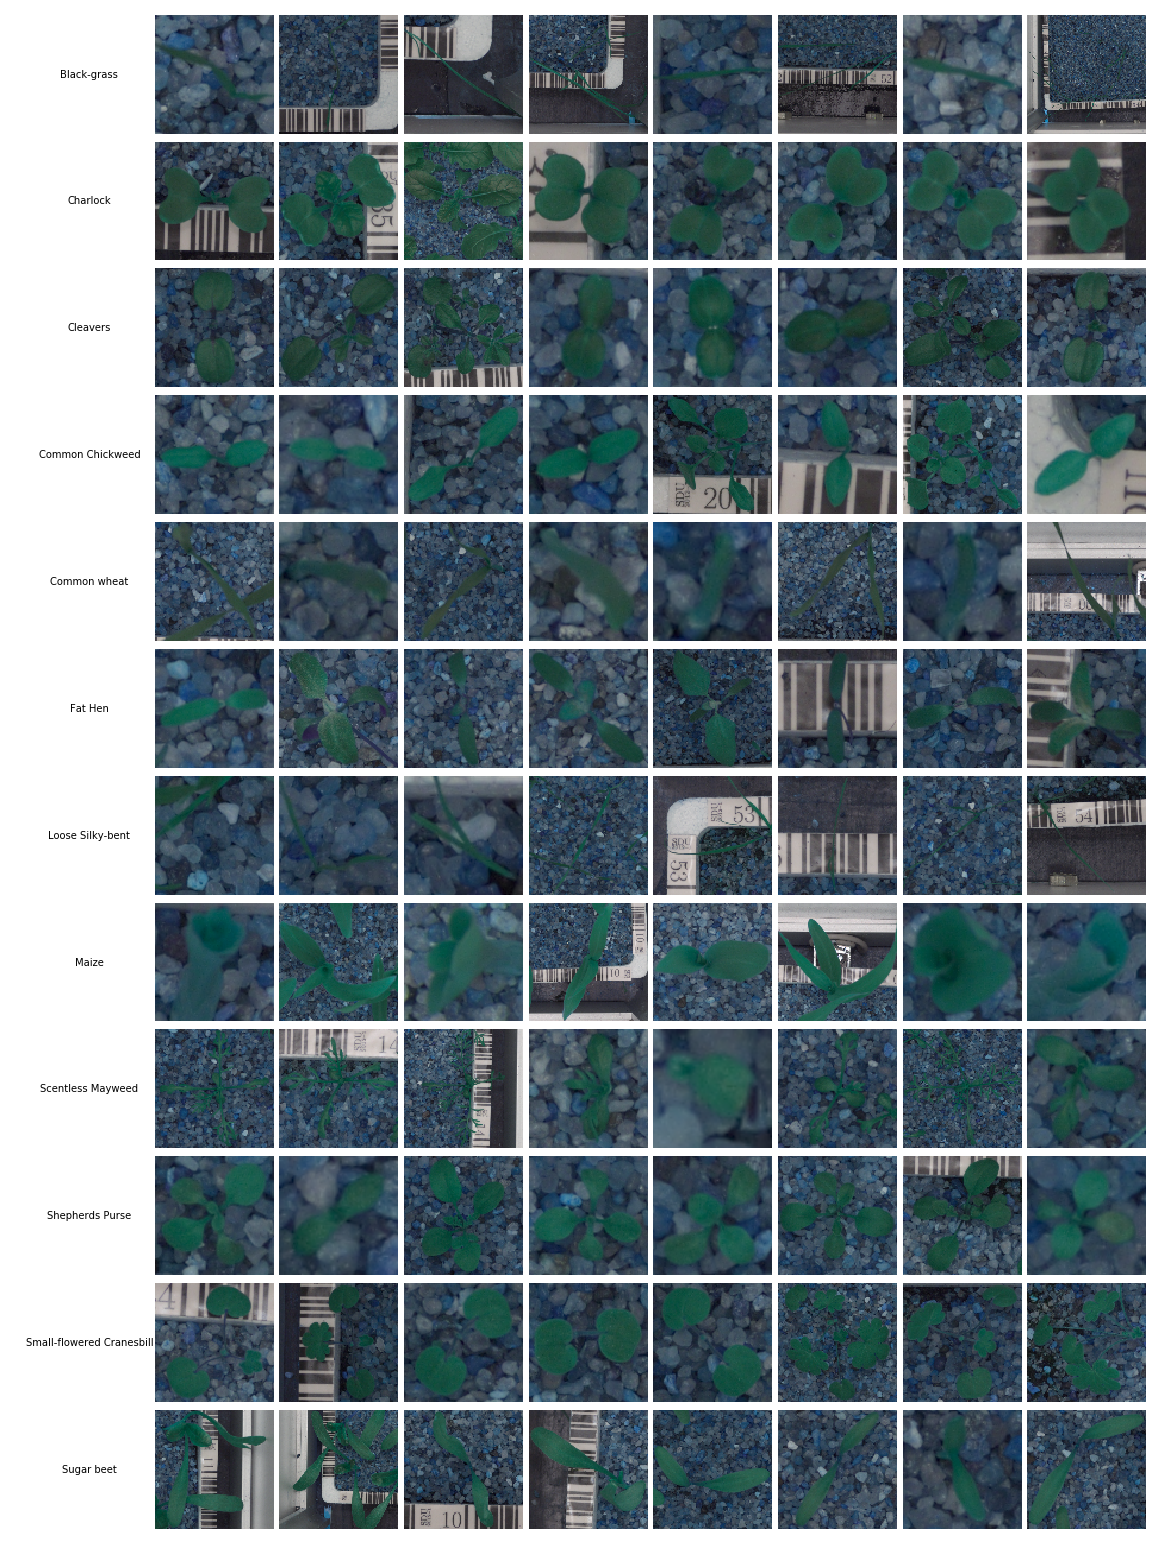

In [0]:
#@title
show_grid_multiple_sample(all_train_df, species_groups)

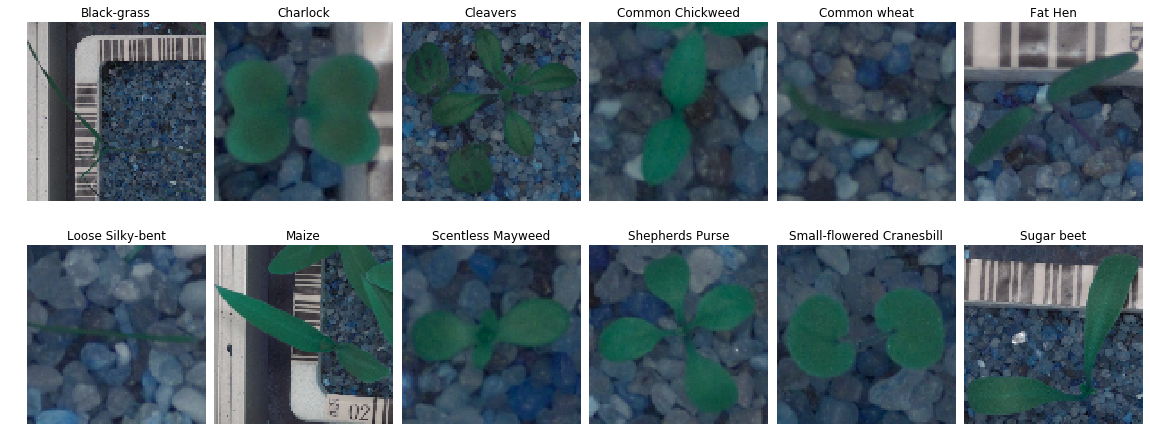

In [0]:
#@title
show_grid_one_sample(all_train_df, species_groups)

#### 3.1.2.2 Species group distribution

The distribution visualization demonstrates an imbalance in the dataset weed types or groups.

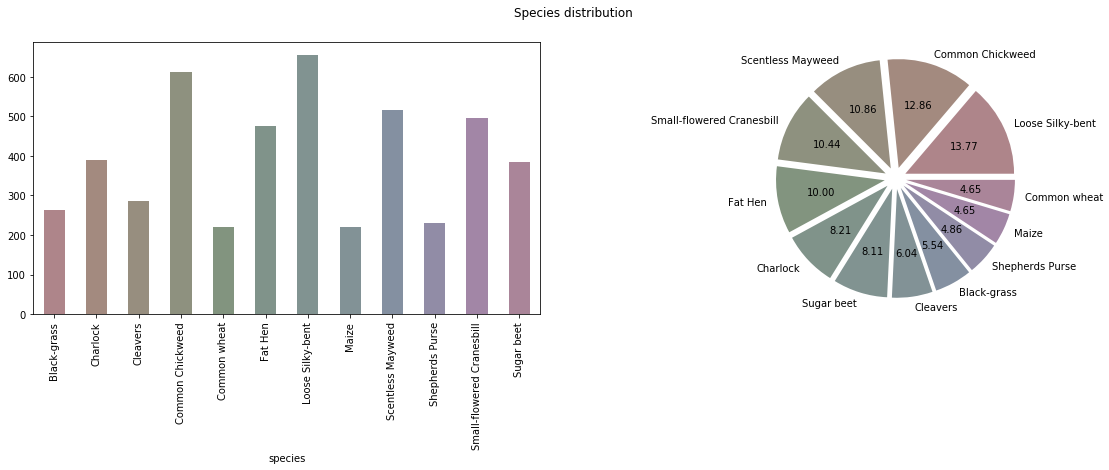

In [0]:
#@title
show_species_distribution(all_train_df)

#### 3.1.2.3 PCA & TSNE

The PCA and t-SNE can be applied for dimensionality reduction to images on 2D and 3D. There is no clear clustering or similarity on the lower dimensions (at least before applying the pre-processing segmentation process).

NOTE: The number of sample images are reduced to 500 images to avoid long loading times.

In [0]:
#@title
if TSNE_VISUALIZATION:
    sample_df = all_train_df.sample(500)
    sample_images, _ = load_species_images(sample_df, IMAGE_WIDTH, IMAGE_HEIGHT)

In [0]:
#@title
if TSNE_VISUALIZATION:
    flatten_images = [image.flatten() for image in sample_images]
    pca_results = apply_PCA(flatten_images)
    tsne_results = apply_TSNE(pca_results)
    plot_TSNE_results(tsne_results, sample_df['species'].values)

In [0]:
#@title
if TSNE_VISUALIZATION:
    tsne_results = apply_TSNE(pca_results, n_components = 3)
    plot_TSNE_results(tsne_results, sample_df['species'].values, TSNE_dimension.THREE)

## 3.2 Conclusions

From the descriptive analysis some of the conclusions are:
- There is an imbalance on the dataset which should be handled to avoid training biases.
- There are not much images for training deep learning models so we should use data augmentation to increase the dataset.
- All weed images have backgrounds that we should be removed in order to improve weed recognition.
- There is no clear clustering on lower dimensions before pre-processing.

# 4. Pre-processing

This are the principal concerns that should be addressed on the pre-processing from the data analysis:

1. Balance the dataset to avoid biases on imbalance weed types.
2. Use image segmentation to remove background as to focus on weed recognition.
3. Apply data augmentation to increase the data available for training.

## 4.1 Balance dataset

The class weights computation allows to handle unbalance data distribution by weighting the class importance on training.

Other ways of balancing the dataset are oversampling and undersampling with methods like SMOTE and ADASYN.

In [0]:
#@title
def compute_class_weights(data_groups) :
    return dict(enumerate(compute_class_weight("balanced", np.unique(data_groups), data_groups)))

In [0]:
#@title
class_weights = compute_class_weights(all_train_df['species'])
print(f"This are the class weights that will be use for training to balance the dataset: {class_weights}")

This are the class weights that will be use for training to balance the dataset: {0: 1.5050697084917617, 1: 1.014957264957265, 2: 1.3792102206736354, 3: 0.6478450627386798, 4: 1.7911010558069382, 5: 0.8333333333333334, 6: 0.605249745158002, 7: 1.7911010558069382, 8: 0.7671188630490956, 9: 1.7135642135642135, 10: 0.7980510752688172, 11: 1.0281385281385282}


## 4.2 Segmentation
The segmentation process masks the main object of analysis by removing all unnecessary background.

In this section the segmentation operation is applied to a single image with the following steps:

1. Mask creation 
  1. Change the color space from RGB to HSV. This is an easier space to define color ranges.
  2. Define the color range for green (common weed color).
  3. Define the most common shape for weeds. For this case close ellipses.
  4. Apply the morphology transformation to identify the weeds within the color range and shape. 
2. Apply mask to remove background

Further information can be found on openCV documentation on [colorspaces](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) and [Morphological Transformations](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

In [0]:
#@title
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    segmented = segment_plant(image)
    image_blurred = cv2.GaussianBlur(segmented, (0, 0), 3)
    image_sharp = cv2.addWeighted(segmented, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def create_image_tranformation(image):
    masked_image = create_mask_for_plant(image)
    segmented_image = segment_plant(image)
    
    return masked_image, segmented_image

def load_species_images_with_segmentation(species_data, image_width, image_height):
    return load_species_images(species_data, image_width, image_height, segment_plant)

def plot_image_transformation(original_image, masked_image, segmented_image):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 10))
    axs[0].imshow(original_image)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(masked_image)
    axs[1].axis('off')
    axs[1].set_title('Masked image')
    axs[2].imshow(segmented_image)
    axs[2].set_title('Segmented image')
    axs[2].axis('off')

100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


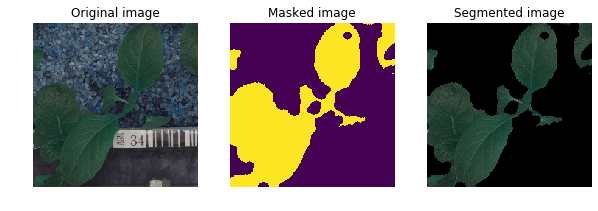

In [0]:
#@title
sample_image, _ = load_species_images(all_train_df.sample(1), IMAGE_WIDTH, IMAGE_HEIGHT)
masked_image, segmented_image = create_image_tranformation(sample_image[0])
plot_image_transformation(sample_image[0], masked_image, segmented_image)

Applying t-SNE again on the same sample images but now with segmentation.

In [0]:
#@title
if TSNE_VISUALIZATION:
    sample_images, _ = load_species_images_with_segmentation(sample_df, IMAGE_WIDTH, IMAGE_HEIGHT)
    flatten_images = [image.flatten() for image in sample_images]
    plot_TSNE_with_PCA(flatten_images, sample_df['species'].values, TSNE_dimension.TWO)

## 4.2 Data augmentation

For the data augmentation we can use keras preprocessing library [ImageDataGenerator](https://keras.io/preprocessing/image/).

The class can generate batches of tensor image data with real-time data augmentation while training the model. This are the transformations apply to augment the data:
- Random rotations within a range define by rotation_range.
- Random zooms within a range define by zoom_range.
- Random width shifts define by width_shift_range.
- Random heigh shifts define by height_shift_range.
- Random horizontal flips.
- Random vertical flips.

NOTE: All this variables can be configured at the beginning of the notebook.

This section will show some random transformations on a number of sample images.

In [0]:
#@title
def create_image_data_generator(
    rotation_range = 0,  
    zoom_range = 0,
    width_shift_range = 0, 
    height_shift_range = 0, 
    horizontal_flip = False,
    vertical_flip = False,
    rescale = None,
    preprocessing_function = None
):
    return ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = rotation_range,
        zoom_range = zoom_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        preprocessing_function = preprocessing_function
    )
    
def show_augmentation_row(original_image, images_iterator, number_of_augmentations, axes):   
    axes[0].axis('off')
    axes[0].set_title('Original image')
    axes[0].imshow(original_image)
    
    for image_number in range(number_of_augmentations):
        image = images_iterator.next()
        axes[image_number + 1].axis('off')
        axes[image_number + 1].set_title('Augmented image')
        axes[image_number + 1].imshow(image[0].astype(np.uint8))

def show_grid_with_augmented_images(number_of_samples, number_of_augmentations, image_data_generator):   
    fig, axes = plt.subplots(nrows = number_of_samples, ncols = number_of_augmentations + 1, figsize = (30, 4 * number_of_samples), gridspec_kw = {'wspace': 0.05, 'hspace': 0.05})
    fig.suptitle('Sample augmented images', fontsize=16)
    
    sample_images, _ = load_species_images_with_segmentation(all_train_df.sample(number_of_samples), IMAGE_WIDTH, IMAGE_HEIGHT)
    for sample_id, sample_image in enumerate(sample_images):
        images_iterator = image_data_generator.flow(np.expand_dims(sample_image, axis=0), None, 1)
        show_augmentation_row(sample_image, images_iterator, number_of_augmentations, axes[sample_id])
    
    plt.show()

In [0]:
#@title
image_data_generator = create_image_data_generator(
    rotation_range = 250,    
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
)

100%|██████████| 5/5 [00:00<00:00, 77.98it/s]


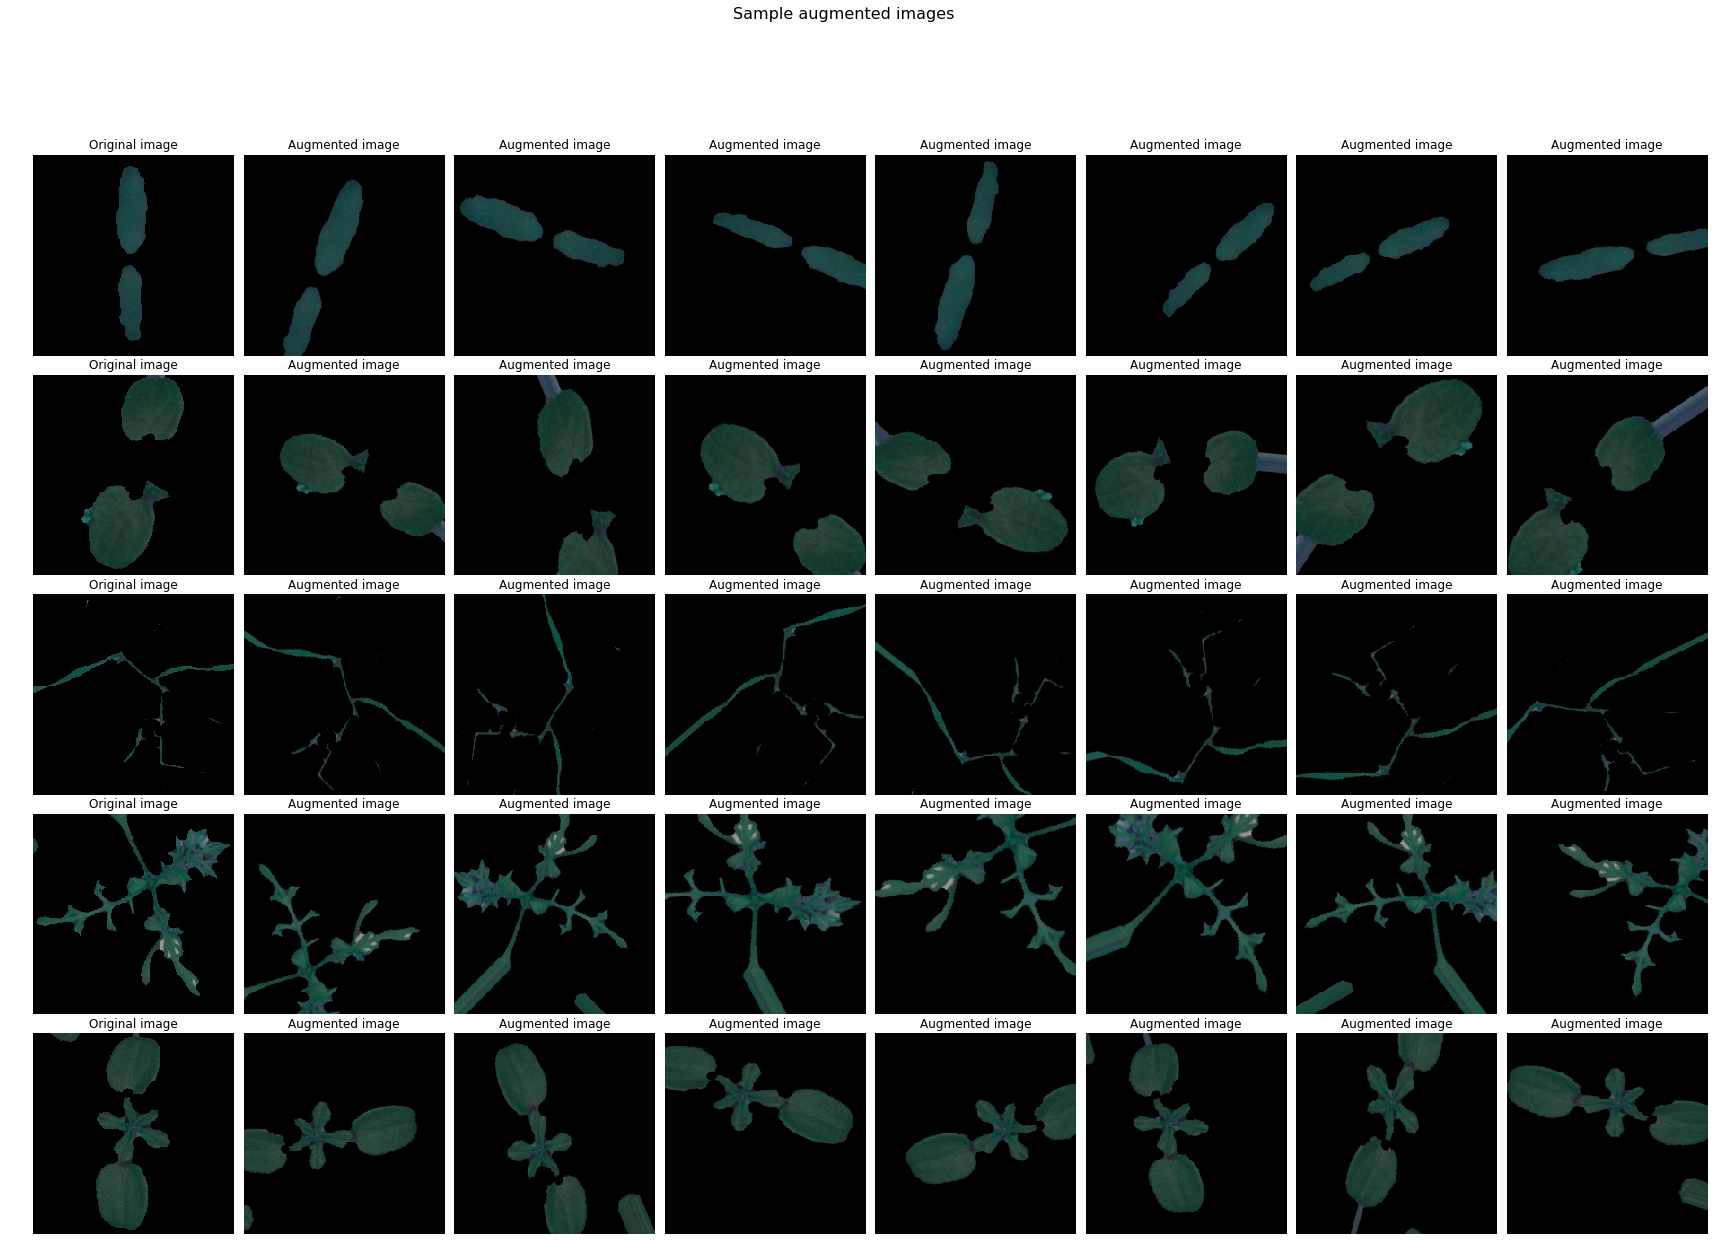

In [0]:
#@title
show_grid_with_augmented_images(number_of_samples = 5, number_of_augmentations = 7, image_data_generator = image_data_generator)

# 5. Processing

This section describes the model architecture and the training process. This are the following architectures use for training:

Convolutional model to extract features from images:
- **Pre-trained models**: This models are use for transfer learning by reusing their weights/layers and retraining only the classifier for the specific domain. 
- **Custom CNN**: This is a multi-layer CNN using batch normalization and regularization.

Classifier model to classify high level features:
- Fully connected network: Fully connected network with dense layers, normalization, regularization and the use of softmax for classification. 
- XGBoost:
- SVM:

For the pre-trained will use transfer learning and fine tuning as explain on [tensorflow documentaion](https://www.tensorflow.org/tutorials/images/transfer_learning).

- **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

- **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

Also different metrics are use to validate the model like accuracy, recall, f1-score and the confusion matrix.

The training set is divided in training (80%), validation (10%) and test sets (10%).

The CONVOLUTIONAL_MODEL parameter (at the beginning of the notebook) can be used to select the model to train:

- CUSTOM_CNN: Custom multi-layer CNN.
- RESNET_V2: Pre-trained model [Resnet_v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2).
- INCEPTION_V3: Pre-trained model [InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3).
- XCEPTION: Pre-trained model [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception)
- INCEPTION_RESNET_V2: Pre-trained model [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionResNetV2)
- VGG16: Pre-trained model [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)
- VGG19: Pre-trained model [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)
- MOBILE_NET_V2: Pre-trained model [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)
- NASNET_MOBILE: Pre-trained model [NASNetMobile](https://www.tensorflow.org/api_docs/python/tf/keras/applications/NASNetMobile)

Models can be setup with the following parameters.
- **preprocessing_function**: This are important for the pre-trained models which usually have a preprocess_input function. For more information please refer to the [keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications)
- **rescale**: Usually a typical rescaling is from [0 - 255] to [0 - 1] which works best on model training.
- **base_model**: Function returning the convolutional network to extract features.
- **classifier**: Function returning the classifier to classify features.
- **image_transformation**: Function to preprocess images like segmentation.
- **layers_to_fine_tune**: Number of layers to fine tune after training FNN classifier.

NOTE: It should be easy to add additional pre-trained models if desired.

Some additional improvements, not implemented on this notebook yet, are:

- ~~Fine tune pre-trained models by unfreezing and training the last layers on the CNN.~~
- ~~Use more classifiers like XGBoost, SVM, LightGBM, Random Forest, etc. instead of just the FNN.~~
- ~~Use hyperparameters optimization using some library like BayesSearchCV, GridSearchCV or RandomizedSearchCV to optimize model parameters.~~
- ~~Use cross-validation to better evaluate the estimator performance.~~
- Use hyperparameters optimization for CNN and FCN like hyperopt.
- Ensemble models to improve performance by combining different models.
- Visualize [CNN filters](https://www.tensorflow.org/tutorials/generative/deepdream)

In [0]:
#@title
number_output_classes = len(get_species_groups())

In [0]:
#@title
class ConvolutionalTrainingModel:
    accuracy_metric = {
        'training': {
            'metric': 'accuracy',
            'label': 'Accuracy'
        },
        'validation': {
            'metric': 'val_accuracy',
            'label': 'Validation accuracy'
        }
    }
    loss_metric = {
        'training': {
            'metric': 'loss',
            'label': 'Loss'
        },
        'validation': {
            'metric': 'val_loss',
            'label': 'Validation loss'
        }
    }
    
    def __init__(
        self, 
        image_data_generator_for_training, 
        image_data_generator_for_validation, 
        image_data_generator_for_prediction,
        base_model,
        classifier_model
    ):
        self.image_data_generator_for_training = image_data_generator_for_training
        self.image_data_generator_for_validation = image_data_generator_for_validation
        self.image_data_generator_for_prediction = image_data_generator_for_prediction
        self.optimizer = Adam(lr = 1e-3)
        self.fine_tune_optimizer = Adam(lr = 1e-5)
        self.loss = 'categorical_crossentropy'
        self.metrics = [ConvolutionalTrainingModel.accuracy_metric['training']['metric']]
        self.training_results = None
        self.species_names = get_species_groups()
        self.base_model = base_model
        
        self.training_model = self.create_model(base_model, classifier_model)
    
    def create_model(self, base_model, classifier_model):
        model = Sequential(name = "Species-Prediction")
        model.add(base_model)
        model.add(classifier_model)

        model.compile(optimizer = self.optimizer, loss = self.loss, metrics = self.metrics)  
        model.summary()

        return model

    def train_model(
        self,
        train_X,
        train_y,
        validation_data_X,
        validation_data_y,
        batch_size,
        epochs,
        patience,
        class_weights
    ):
        print(f"Modeling training with {batch_size} batch size, {patience} patience for {epochs} epochs")
              
        self.image_data_generator_for_training.fit(train_X)
        self.image_data_generator_for_validation.fit(validation_data_X)
        modelcheck = ModelCheckpoint(os.path.join('', 'weights.h5'), monitor = 'val_loss', save_best_only = True, verbose = 0)
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = patience, verbose = 1, restore_best_weights = True)
        lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta = 1e-5, patience = patience, verbose = 1)

        self.training_results = self.training_model.fit(
            self.image_data_generator_for_training.flow(train_X, train_y, batch_size),
            epochs = epochs,
            validation_data = self.image_data_generator_for_validation.flow(validation_data_X, validation_data_y, batch_size),
            steps_per_epoch = int(len(train_X) / batch_size),
            validation_steps = int(len(validation_data_X) / batch_size),
            callbacks = [earlystopper, lr_reduce, modelcheck],
            class_weight = class_weights
        )
    
    def extract_features_with_labels(
        self,
        train_X,
        train_Y,
        batch_size
    ):
        return self.extract_features(train_X, batch_size), np.argmax(train_Y.values, axis = 1)
    
    def extract_features(
        self,
        train_X,
        batch_size
    ):
        self.image_data_generator_for_prediction.fit(train_X)
        features = self.base_model.predict(self.image_data_generator_for_prediction.flow(train_X, batch_size = batch_size, shuffle = False))
        
        return features.reshape(features.shape[0], -1)
        
    def predict(self, x, batch_size):
        self.image_data_generator_for_prediction.fit(x)
        return self.training_model.predict(self.image_data_generator_for_prediction.flow(x, batch_size = batch_size, shuffle = False), verbose = 1)
    
    def predict_species_class(self, x, batch_size):
        return np.argmax(self.predict(x, batch_size), axis = 1)
    
    def predict_species_name(self, x, batch_size):
        return [self.species_names[species_class] for species_class in self.predict_species_class(x, batch_size)]

    def eval_model(self, test_X, test_Y, field_name = 'species'):
        """
        Model evaluation: plots, classification report
        @param training: model training history
        @param model: trained model
        @param test_X: features 
        @param test_y: labels
        @param field_name: label name to display on plots
        """        
        self.image_data_generator_for_prediction.fit(test_X) 
        test_pred = self.training_model.predict(self.image_data_generator_for_prediction.flow(test_X, batch_size = batch_size, shuffle = False))
        
        self.plot_metrics(test_Y, test_pred, field_name)
        self.plot_classification_report(self.image_data_generator_for_prediction.flow(test_X, test_Y, batch_size = batch_size, shuffle = False), test_Y, test_pred)
        self.plot_confusion_matrix(test_Y, test_pred)
    
    def configure_fine_tuning(self, layers_to_fine_tune = 10):
        print(f"Fine training model with the following layers:")
        for i, layer in enumerate(self.base_model.layers):
            print(f'Layer {i} -> {layer.name}')
        
        for layer in base_model.layers[: -layers_to_fine_tune]:
            layer.trainable = True
        
        self.training_model.compile(optimizer = self.fine_tune_optimizer, loss = self.loss, metrics = self.metrics) 
        
    def plot_metrics(self, test_y, test_pred, field_name = 'species'):
        fig, axes = plt.subplots(1, 3, figsize = (20, 7))
        
        self.plot_metric(ConvolutionalTrainingModel.accuracy_metric, axes[0], field_name)
        self.plot_metric(ConvolutionalTrainingModel.loss_metric, axes[1], field_name)
        self.plot_accuracy_by_species_group(test_y, test_pred, axes[2], field_name)

        plt.tight_layout()
        plt.show()
        
    def plot_metric(self, metric, axes, field_name):
        axes.plot(self.training_results.history[metric['training']['metric']], label = metric['training']['label'])
        axes.plot(self.training_results.history[metric['validation']['metric']], label = metric['validation']['label'])
        axes.set_title(f'{field_name} {metric["training"]["metric"]}')
        axes.set_xlabel('Epoch')
        axes.set_ylabel(metric['training']['label'])
        axes.legend()
 
    def plot_accuracy_by_species_group(self, test_y, test_pred, axes, field_name):
        acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum() / test_y.sum()
        acc_by_subspecies.plot.bar(title = f'Accuracy by {field_name}', ax = axes)
        plt.ylabel('Accuracy')
    
    def plot_classification_report(self, iterator_test_X, test_y, test_pred):
        print("Classification report")
        test_pred = np.argmax(test_pred, axis = 1)
        test_truth = np.argmax(test_y.values, axis = 1)

        print(metrics.classification_report(test_truth, test_pred, target_names = test_y.columns, zero_division = True))

        test_res = self.training_model.evaluate(iterator_test_X, verbose = 0)
        print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
        
    def plot_confusion_matrix(self, test_Y, test_pred):
        cnf_matrix = metrics.confusion_matrix(np.argmax(test_Y.values, axis = 1), np.argmax(test_pred, axis = 1))

        abbreviation = ['Bg', 'Ch', 'Cl', 'CC', 'Cw', 'FH', 'LSb', 'M', 'SM', 'SP', 'SfC', 'Sb']
        pd.DataFrame({'class': self.species_names, 'abbreviation': abbreviation})

        fig, ax = plt.subplots(1, 1, figsize = (10, 10))
        ax = sns.heatmap(cnf_matrix, ax = ax, cmap = plt.cm.Greens, annot = True)
        ax.set_xticklabels(abbreviation)
        ax.set_yticklabels(abbreviation)
        plt.title('Confusion matrix of test set')
        plt.ylabel('True species')
        plt.xlabel('Predicted species')
        
        plt.show();

In [0]:
#@title
def split(data):
    train_data, validation_data = train_test_split(data, test_size = 0.2, shuffle = True)
    validation_data, test_data = train_test_split(validation_data, test_size = 0.5, shuffle = True)

    return (train_data, validation_data, test_data)
        
def create_FCN_classifier_global_max_pooling(batch_normalization = False, dropout = False, kernel_regularizer = None):
    model = Sequential(name = 'GlobalMaxPooling-FCN-classifier')
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1024, kernel_regularizer = kernel_regularizer, name = "dense1", activation = 'relu'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(1024, kernel_regularizer = kernel_regularizer, name = "dense2", activation = 'relu'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(number_output_classes, activation = 'softmax', name = 'predictions'))
        
    return model

def create_FCN_classifier_global_average_pooling(batch_normalization = False, dropout = False, kernel_regularizer = None):
    model = Sequential(name = 'GlobalAveragePooling-FCN-classifier')
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(1024, kernel_regularizer = kernel_regularizer, name = "dense1", activation = 'relu'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(number_output_classes, activation = 'softmax', name = 'predictions'))
        
    return model

def create_global_average_pooling():
    model = Sequential(name = 'GlobalAveragePooling')
    model.add(GlobalAveragePooling2D())
        
    return model
    
def create_FCN_classifier_with_flatten(batch_normalization = False, dropout = False, kernel_regularizer = None):
    model = Sequential(name = 'Flatten-FCN-classifier')
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu", kernel_regularizer = kernel_regularizer, name='dense1'))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Dropout(0.5)) if (dropout) else False
    model.add(Dense(number_output_classes, activation = "softmax", name='predictions'))
    
    return model
    
def create_inceptionV3_model():
    base_model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_vgg16_model():
    base_model = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
     
    return base_model

def create_vgg19_model():
    base_model = vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
     
    return base_model

def create_resnetv2_model():
    base_model = resnet_v2.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_inceptionResNetV2_model():
    base_model = inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_xception_model():
    base_model = xception.Xception(weights = 'imagenet', include_top = False, pooling = 'avg', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False

    return base_model

def create_densenet201_model():
    base_model = densenet.DenseNet201(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
 
    return base_model

def create_mobilenet_v2_model():
    base_model = mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
 
    return base_model

def create_nasnet_mobile_model():
    base_model = nasnet.NASNetMobile(weights = 'imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    for layer in base_model.layers:
        layer.trainable = False
 
    return base_model

def create_simple_convolutional_base(batch_normalization = False):
    model = Sequential(name = 'Three-Layer-CNN-base')
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), name="conv_layer_1.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', name="conv_layer_1.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_2.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_2.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
        
    model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_3.1"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu', name = "conv_layer_3.2"))
    model.add(BatchNormalization()) if (batch_normalization) else False
    model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
    
    return model

In [0]:
#@title
default_classifier = lambda: create_FCN_classifier_global_average_pooling(batch_normalization = True, dropout = True, kernel_regularizer = l2(0.01))
default_image_transformation = segment_plant
default_layers_to_fine_tune = 5
TRAINING_MODELS_CONFIGURATION = {
    ConvolutionalModel.CUSTOM_CNN: {
        'preprocessing_function': None,
        'rescale': 1. / 255,
        'base_model': create_simple_convolutional_base,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': None
    },
    ConvolutionalModel.RESNET_V2: {
        'preprocessing_function': resnet_v2.preprocess_input,
        'rescale': None,
        'base_model': create_resnetv2_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.INCEPTION_V3: {
        'preprocessing_function': inception_v3.preprocess_input,
        'rescale': None,
        'base_model': create_inceptionV3_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.XCEPTION: {
        'preprocessing_function': xception.preprocess_input,
        'rescale': None,
        'base_model': create_xception_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.INCEPTION_RESNET_V2: {
        'preprocessing_function': inception_resnet_v2.preprocess_input,
        'rescale': None,
        'base_model': create_inceptionResNetV2_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.VGG16: {
        'preprocessing_function': vgg16.preprocess_input,
        'rescale': None,
        'base_model': create_vgg16_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.VGG19: {
        'preprocessing_function': vgg19.preprocess_input,
        'rescale': None,
        'base_model': create_vgg19_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.MOBILE_NET_V2: {
        'preprocessing_function': mobilenet_v2.preprocess_input,
        'rescale': None,
        'base_model': create_mobilenet_v2_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    },
    ConvolutionalModel.NASNET_MOBILE: {
        'preprocessing_function': nasnet.preprocess_input,
        'rescale': None,
        'base_model': create_nasnet_mobile_model,
        'classifier': default_classifier,
        'image_transformation': default_image_transformation,
        'layers_to_fine_tune': default_layers_to_fine_tune
    }
}

def get_classifier(classifier_model):
    # Use global average pooling to reduce features dimensions if we want to use other classifiers like XGBoost, SVM, etc.
    return TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['classifier']() if classifier_model == ClassifierModel.FCN else create_global_average_pooling()

In [0]:
#@title
image_transformation = TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['image_transformation']

train_data, validation_data, test_data = split(all_train_df)

train_X, train_Y = load_species_images(train_data, IMAGE_WIDTH, IMAGE_HEIGHT, image_transformation)
validation_X, validation_Y = load_species_images(validation_data, IMAGE_WIDTH, IMAGE_HEIGHT, image_transformation)
test_X, test_Y = load_species_images(test_data, IMAGE_WIDTH, IMAGE_HEIGHT, image_transformation)

100%|██████████| 475/475 [00:05<00:00, 90.23it/s]


In [0]:
#@title
preprocessing_function = TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['preprocessing_function']
rescale = TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['rescale']
base_model = TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['base_model']()
classifier_model = get_classifier(CLASSIFIER_MODEL)

image_data_generator_for_training = create_image_data_generator(
    rotation_range,
    zoom_range,
    width_shift_range,
    height_shift_range,
    horizontal_flip,
    vertical_flip,
    rescale,
    preprocessing_function
)

image_data_generator_for_validation = create_image_data_generator(
    rescale = rescale,
    preprocessing_function = preprocessing_function
)

image_data_generator_for_prediction = create_image_data_generator(
    rescale = rescale,
    preprocessing_function = preprocessing_function
)

model = ConvolutionalTrainingModel(
    image_data_generator_for_training,
    image_data_generator_for_validation,
    image_data_generator_for_prediction,
    base_model,
    classifier_model
)

94674944/94668760 [==============================] - 3s 0us/step
Model: "Species-Prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
GlobalAveragePooling-FCN-cla (None, 12)                2114572   
Total params: 25,679,372
Trainable params: 2,112,524
Non-trainable params: 23,566,848
_________________________________________________________________


For hyperparameter optimization there are several methods with [scikit-learn](https://scikit-learn.org/stable/) and [scikit-optimize](https://scikit-optimize.github.io/stable/):
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- [BayesSearchCV](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

As mention in its website:
> Search for parameters of machine learning models that result in best cross-validation performance is necessary in almost all practical cases to get a model with best generalization estimate. A standard approach in scikit-learn is using sklearn.model_selection.GridSearchCV class, which takes a set of values for every parameter to try, and simply enumerates all combinations of parameter values. The complexity of such search grows exponentially with the addition of new parameters. A more scalable approach is using sklearn.model_selection.RandomizedSearchCV, which however does not take advantage of the structure of a search space.
> 
> Scikit-optimize provides a drop-in replacement for sklearn.model_selection.GridSearchCV, which utilizes Bayesian Optimization where a predictive model referred to as “surrogate” is used to model the search space and utilized to arrive at good parameter values combination as soon as possible.

In [0]:
#@title
class ClassifierTrainingModel:
    n_splits = 3
    
    def __init__(self, estimator, search_spaces, scoring, convolutional_model, iterations = 5):
        self.bayes_search = BayesSearchCV(
            estimator = estimator,
            search_spaces = search_spaces,
            scoring = scoring,
            cv = StratifiedKFold(
                n_splits = ClassifierTrainingModel.n_splits,
                shuffle = True,
                random_state = 42
            ),
            n_jobs = 3,
            n_iter = iterations,   
            verbose = 1,
            refit = True,
            random_state = 42
        )
        self.convolutional_model = convolutional_model
        self.species_names = get_species_groups()
    
    def fit(self, features, labels):
        return self.bayes_search.fit(features, labels, callback = self.print_optimization_status)
    
    def score(self, features, labels):
        return self.bayes_search.score(features, labels)
    
    def predict(self, images, batch_size):
        features, _ = self.convolutional_model.extract_features(images, batch_size)
        return self.bayes_search.predict(features)
    
    def predict_species_class(self, images, batch_size):
        return np.argmax(self.predict(images, batch_size), axis = 1)
    
    def predict_species_name(self, images, batch_size):
        return [self.species_names[species_class] for species_class in self.predict_species_class(images)]
        
    def print_optimization_status(self, results):
        """Status callback during bayesian hyperparameter search"""
        all_models = pd.DataFrame(self.bayes_search.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(self.bayes_search.best_params_)
        print(f'Model #{len(all_models)}\nBest Log loss: {np.round(self.bayes_search.best_score_, 4)}\nBest params: {self.bayes_search.best_params_}\n')

Modeling training with 32 batch size, 10 patience for 500 epochs
Train for 118 steps, validate for 14 steps
Epoch 1/500
118/118 [==============================] - 75s 635ms/step - loss: 11.9844 - accuracy: 0.3915 - val_loss: 9.9116 - val_accuracy: 0.5201
Epoch 2/500
118/118 [==============================] - 68s 574ms/step - loss: 8.8377 - accuracy: 0.4806 - val_loss: 8.0620 - val_accuracy: 0.4665
Epoch 3/500
118/118 [==============================] - 69s 582ms/step - loss: 6.9886 - accuracy: 0.4756 - val_loss: 6.1988 - val_accuracy: 0.5446
Epoch 4/500
118/118 [==============================] - 69s 585ms/step - loss: 5.5595 - accuracy: 0.5199 - val_loss: 5.3151 - val_accuracy: 0.4509
Epoch 5/500
118/118 [==============================] - 69s 587ms/step - loss: 4.6227 - accuracy: 0.5342 - val_loss: 4.3960 - val_accuracy: 0.5112
Epoch 6/500
118/118 [==============================] - 69s 582ms/step - loss: 3.9919 - accuracy: 0.5231 - val_loss: 3.7058 - val_accuracy: 0.5156
Epoch 7/500
118

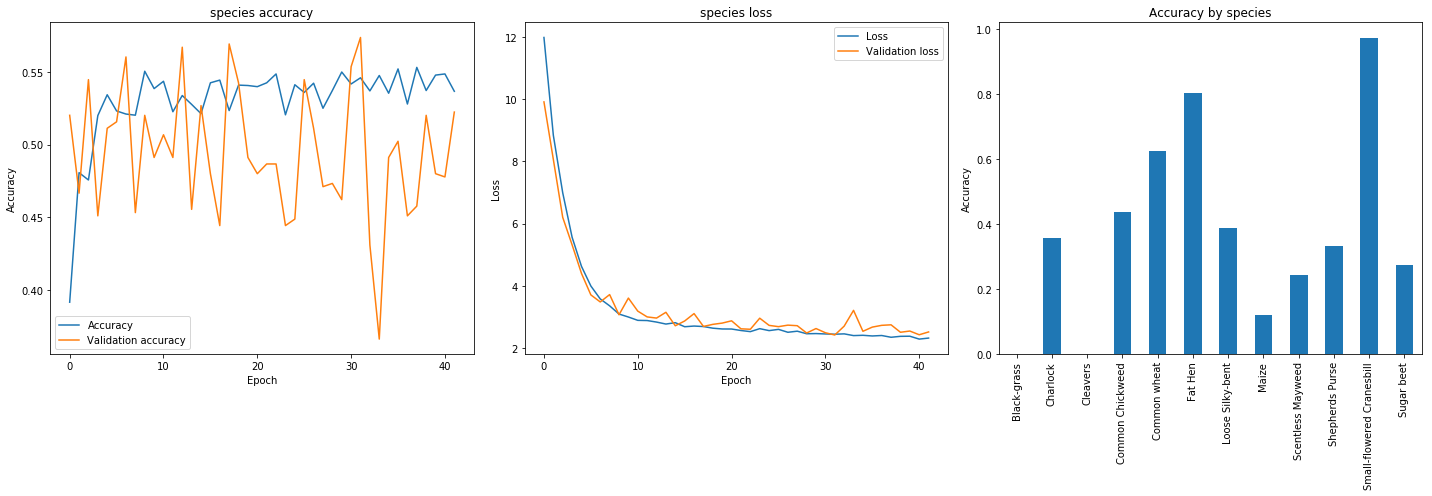

Classification report
                           precision    recall  f1-score   support

              Black-grass       0.24      0.24      0.24        17
                 Charlock       0.63      0.55      0.59        53
                 Cleavers       1.00      0.00      0.00        27
         Common Chickweed       0.46      0.58      0.52        55
             Common wheat       0.39      0.67      0.49        24
                  Fat Hen       0.62      0.91      0.74        46
         Loose Silky-bent       0.79      0.60      0.68        80
                    Maize       0.40      0.24      0.30        25
        Scentless Mayweed       0.86      0.45      0.59        53
          Shepherds Purse       0.42      0.61      0.50        18
Small-flowered Cranesbill       0.43      1.00      0.60        37
               Sugar beet       0.89      0.40      0.55        40

                 accuracy                           0.56       475
                macro avg       0.59  

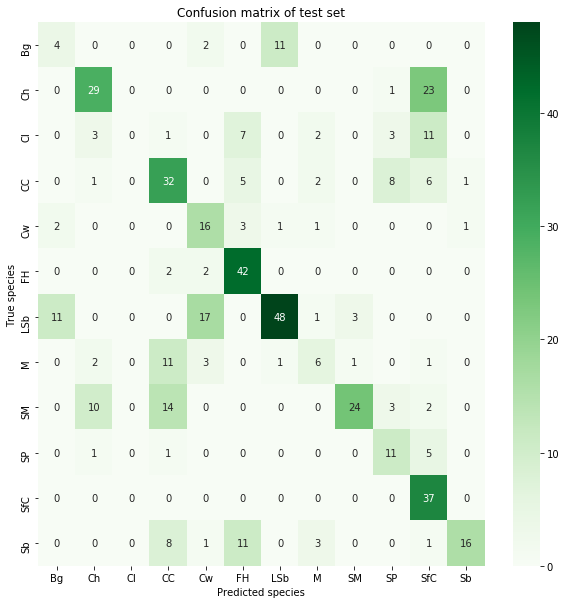

Fine training model with the following layers:
Layer 0 -> input_1
Layer 1 -> conv1_pad
Layer 2 -> conv1_conv
Layer 3 -> pool1_pad
Layer 4 -> pool1_pool
Layer 5 -> conv2_block1_preact_bn
Layer 6 -> conv2_block1_preact_relu
Layer 7 -> conv2_block1_1_conv
Layer 8 -> conv2_block1_1_bn
Layer 9 -> conv2_block1_1_relu
Layer 10 -> conv2_block1_2_pad
Layer 11 -> conv2_block1_2_conv
Layer 12 -> conv2_block1_2_bn
Layer 13 -> conv2_block1_2_relu
Layer 14 -> conv2_block1_0_conv
Layer 15 -> conv2_block1_3_conv
Layer 16 -> conv2_block1_out
Layer 17 -> conv2_block2_preact_bn
Layer 18 -> conv2_block2_preact_relu
Layer 19 -> conv2_block2_1_conv
Layer 20 -> conv2_block2_1_bn
Layer 21 -> conv2_block2_1_relu
Layer 22 -> conv2_block2_2_pad
Layer 23 -> conv2_block2_2_conv
Layer 24 -> conv2_block2_2_bn
Layer 25 -> conv2_block2_2_relu
Layer 26 -> conv2_block2_3_conv
Layer 27 -> conv2_block2_out
Layer 28 -> conv2_block3_preact_bn
Layer 29 -> conv2_block3_preact_relu
Layer 30 -> conv2_block3_1_conv
Layer 31 -> c

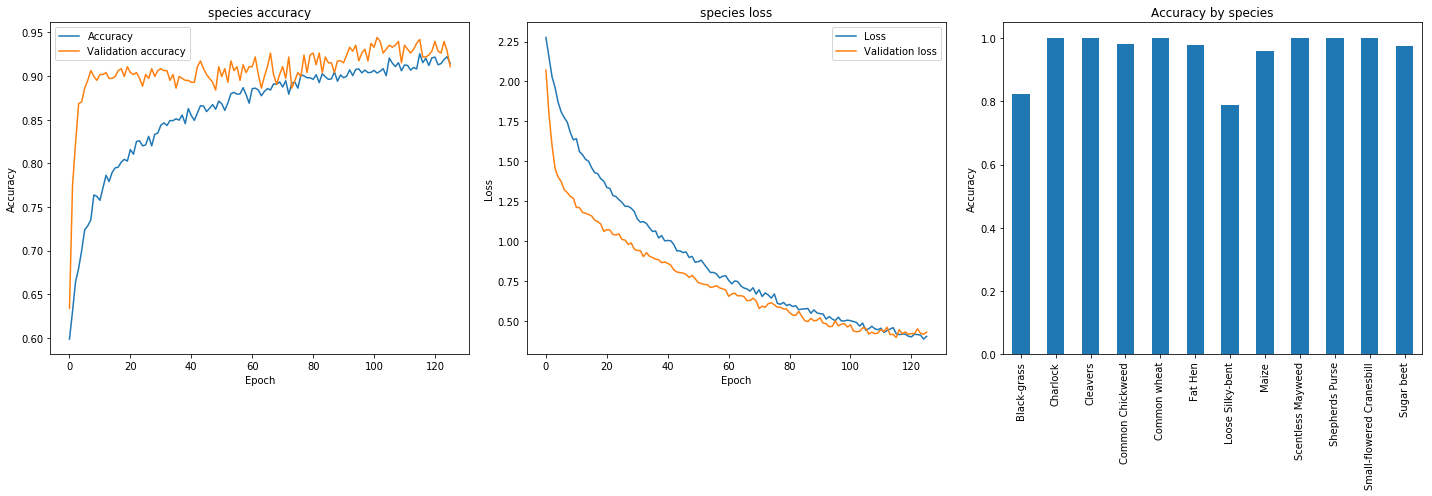

Classification report
                           precision    recall  f1-score   support

              Black-grass       0.47      0.82      0.60        17
                 Charlock       1.00      1.00      1.00        53
                 Cleavers       1.00      1.00      1.00        27
         Common Chickweed       1.00      0.98      0.99        55
             Common wheat       0.89      1.00      0.94        24
                  Fat Hen       1.00      0.98      0.99        46
         Loose Silky-bent       0.97      0.80      0.88        80
                    Maize       1.00      0.96      0.98        25
        Scentless Mayweed       0.98      1.00      0.99        53
          Shepherds Purse       1.00      1.00      1.00        18
Small-flowered Cranesbill       1.00      1.00      1.00        37
               Sugar beet       0.97      0.97      0.97        40

                 accuracy                           0.95       475
                macro avg       0.94  

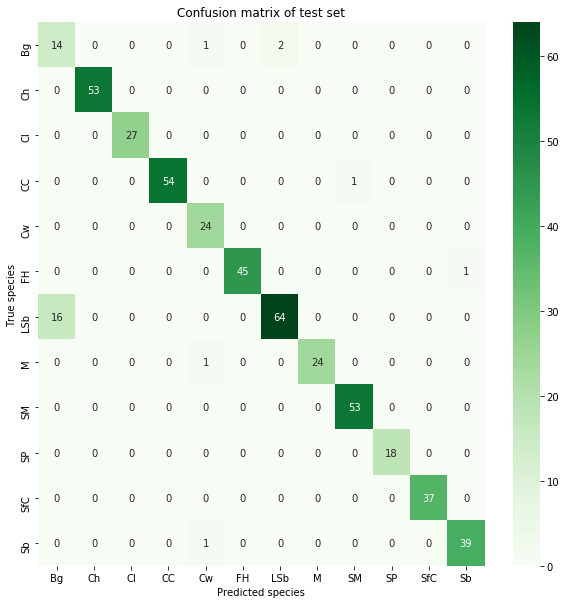

In [0]:
#@title
classifier = None
if CLASSIFIER_MODEL == ClassifierModel.FCN:
    classifier = model
    model.train_model(
        train_X,
        train_Y,
        validation_X,
        validation_Y,
        batch_size,
        epochs,
        patience,
        class_weights
    )
    
    model.eval_model(test_X, test_Y, "species")
    
    layers_to_fine_tune = TRAINING_MODELS_CONFIGURATION[CONVOLUTIONAL_MODEL]['layers_to_fine_tune']
    epochs_to_fine_tune = epochs
    if layers_to_fine_tune != None:
        model.configure_fine_tuning(layers_to_fine_tune)
        model.train_model(
            train_X,
            train_Y,
            validation_X,
            validation_Y,
            batch_size,
            epochs_to_fine_tune,
            patience,
            class_weights
        )
        
        model.eval_model(test_X, test_Y, "species")

In [0]:
#@title
print(f'Available scoring metrics {metrics.SCORERS.keys()}')

Available scoring metrics dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [0]:
#@title
default_scoring = 'balanced_accuracy'
CLASSIFIER_MODELS_CONFIGURATION = {
    ClassifierModel.XGBoost: {
        'estimator': xgb.XGBClassifier(
            objective = 'multi:softmax',
            num_classes = 12,
            verbosity = 1
        ),
        'search_spaces':{
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_child_weight': (0, 10),
            'max_depth': (0, 50),
            'max_delta_step': (0, 20),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'colsample_bylevel': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-9, 1000, 'log-uniform'),
            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
            'gamma': (1e-9, 0.5, 'log-uniform'),
            'min_child_weight': (0, 5),
            'n_estimators': (50, 100),
            'scale_pos_weight': (1e-6, 500, 'log-uniform')
        },
        'scoring': default_scoring
    },
    ClassifierModel.LIGHT_GBM: {
        'estimator': lgb.LGBMClassifier(
            boosting_type = 'gbdt',
            n_jobs = -1,
            verbose = 1,
            objective = 'multiclass',
            class_weight = 'balanced',
        ),
        'search_spaces':{
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'num_leaves': (2, 500),
            'max_depth': (0, 500),
            'min_child_samples': (0, 200),
            'max_bin': (100, 100000),
            'subsample': (0.01, 1.0, 'uniform'),
            'subsample_freq': (0, 10),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'min_child_weight': (0, 10),
            'subsample_for_bin': (100000, 500000),
            'reg_lambda': (1e-9, 1000, 'log-uniform'),
            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
            'scale_pos_weight': (1e-6, 500, 'log-uniform'),
            'n_estimators': (10, 10000)
        },
        'scoring': default_scoring
    },
    ClassifierModel.SVM: {
        'estimator': SVC(
            class_weight = 'balanced',
            verbose = True,
            max_iter = -1
        ),
        'search_spaces':{
            'C': Real(1e-6, 1e+6, prior='log-uniform'),
            'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
            'degree': Integer(1,8),
            'kernel': Categorical(['linear', 'poly', 'rbf'])
        },
        'scoring': default_scoring
    }
}

if CLASSIFIER_MODEL != ClassifierModel.FCN:
    features_train, labels_train = model.extract_features_with_labels(train_X, train_Y, batch_size)
    features_validation, labels_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)
    features_test, labels_test = model.extract_features_with_labels(test_X, test_Y, batch_size)
    
    classifier_configuration = CLASSIFIER_MODELS_CONFIGURATION[CLASSIFIER_MODEL]
    classifier = ClassifierTrainingModel(
        classifier_configuration['estimator'],
        classifier_configuration['search_spaces'],
        classifier_configuration['scoring'],
        model
    )
    
    classifier.fit(features_train, labels_train)
    
    print(f"Training score: {classifier.score(features_train, labels_train)}")
    print(f"Validation score: {classifier.score(features_validation, labels_validation)}")
    print(f"Test score: {classifier.score(features_test, labels_test)}")

In [0]:
#@title
"""
if CLASSIFIER_MODEL == ClassifierModel.XGBoost:
    classifier = xgb.XGBClassifier(
        objective = 'multi:softmax',
        num_classes = 12,
        num_leaves = 15,
        max_depth = 10,
        verbosity = 1,
        learning_rate = 0.1,
        n_jobs = -1,
        min_child_weight = 0.001,
        subsample = 1.0,
        reg_alpha = 0.01,
        reg_lambda = 0.01
    )
    
    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)
    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)
    features_test, label_test = model.extract_features_with_labels(test_X, test_Y, batch_size)
    
    classifier.fit(features_train, label_train, eval_metric = "mlogloss", eval_set = [(features_validation, label_validation)], early_stopping_rounds = patience, verbose = True)
    
    print(f"Training score: {classifier.score(features_train, label_train)}")
    print(f"Validation score: {classifier.score(features_validation, label_validation)}")
    print(f"Test score: {classifier.score(features_test, label_test)}")
"""

'\nif CLASSIFIER_MODEL == ClassifierModel.XGBoost:\n    classifier = xgb.XGBClassifier(\n        objective = \'multi:softmax\',\n        num_classes = 12,\n        num_leaves = 15,\n        max_depth = 10,\n        verbosity = 1,\n        learning_rate = 0.1,\n        n_jobs = -1,\n        min_child_weight = 0.001,\n        subsample = 1.0,\n        reg_alpha = 0.01,\n        reg_lambda = 0.01\n    )\n    \n    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)\n    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)\n    features_test, label_test = model.extract_features_with_labels(test_X, test_Y, batch_size)\n    \n    classifier.fit(features_train, label_train, eval_metric = "mlogloss", eval_set = [(features_validation, label_validation)], early_stopping_rounds = patience, verbose = True)\n    \n    print(f"Training score: {classifier.score(features_train, label_train)}")\n   

In [0]:
#@title
"""
if CLASSIFIER_MODEL == ClassifierModel.SVM:
    from sklearn.svm import SVC
    classifier = SVC(
        C = 1.0,
        kernel = 'rbf',
        degree = 3,
        gamma = 'scale',
        coef0 = 0.0,
        shrinking = True,
        probability = False,
        tol = 0.001,
        cache_size = 200,
        class_weight = 'balanced',
        verbose = False,
        max_iter = -1,
        decision_function_shape = 'ovr',
        break_ties = False,
        random_state = None
    )
    
    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)
    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)
    features_test, label_test = model.extract_features_with_labels(test_X, test_Y, batch_size)
    
    classifier.fit(features_train, label_train)
    
    print(f"Training score: {classifier.score(features_train, label_train)}")
    print(f"Validation score: {classifier.score(features_validation, label_validation)}")
    print(f"Test score: {classifier.score(features_test, label_test)}")
"""

'\nif CLASSIFIER_MODEL == ClassifierModel.SVM:\n    from sklearn.svm import SVC\n    classifier = SVC(\n        C = 1.0,\n        kernel = \'rbf\',\n        degree = 3,\n        gamma = \'scale\',\n        coef0 = 0.0,\n        shrinking = True,\n        probability = False,\n        tol = 0.001,\n        cache_size = 200,\n        class_weight = \'balanced\',\n        verbose = False,\n        max_iter = -1,\n        decision_function_shape = \'ovr\',\n        break_ties = False,\n        random_state = None\n    )\n    \n    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)\n    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)\n    features_test, label_test = model.extract_features_with_labels(test_X, test_Y, batch_size)\n    \n    classifier.fit(features_train, label_train)\n    \n    print(f"Training score: {classifier.score(features_train, label_train)}")\n    print(f"Val

In [0]:
#@title
"""
if CLASSIFIER_MODEL == ClassifierModel.LIGHT_GBM:
    import lightgbm as lgb
    
    classifier = lgb.LGBMClassifier(
        boosting_type = 'gbdt',
        num_leaves = 15,
        max_depth = 5,
        learning_rate = 0.1,
        n_estimators = 1000,
        subsample_for_bin = 200000,
        objective = 'multiclass',
        class_weight = 'balanced',
        min_split_gain = 0.0,
        min_child_weight = 0.001,
        min_child_samples = 20,
        subsample = 1.0,
        subsample_freq = 0,
        colsample_bytree = 1.0,
        reg_alpha = 0.0,
        reg_lambda = 0.0,
        random_state = None,
        n_jobs = -1,
        silent = True,
        importance_type = 'split'
    )
    
    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)
    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)
    features_test, label_test = model.extract_features_with_labels(test_X, test_Y, batch_size)
    
    classifier.fit(features_train, label_train, eval_metric = 'multi_logloss', eval_set = [(features_validation, label_validation)], early_stopping_rounds = patience, verbose = True)
    
    print(f"Training score: {classifier.score(features_train, label_train)}")
    print(f"Validation score: {classifier.score(features_validation, label_validation)}")
    print(f"Test score: {classifier.score(features_test, label_test)}")
"""

'\nif CLASSIFIER_MODEL == ClassifierModel.LIGHT_GBM:\n    import lightgbm as lgb\n    \n    classifier = lgb.LGBMClassifier(\n        boosting_type = \'gbdt\',\n        num_leaves = 15,\n        max_depth = 5,\n        learning_rate = 0.1,\n        n_estimators = 1000,\n        subsample_for_bin = 200000,\n        objective = \'multiclass\',\n        class_weight = \'balanced\',\n        min_split_gain = 0.0,\n        min_child_weight = 0.001,\n        min_child_samples = 20,\n        subsample = 1.0,\n        subsample_freq = 0,\n        colsample_bytree = 1.0,\n        reg_alpha = 0.0,\n        reg_lambda = 0.0,\n        random_state = None,\n        n_jobs = -1,\n        silent = True,\n        importance_type = \'split\'\n    )\n    \n    features_train, label_train = model.extract_features_with_labels(train_X, train_Y, batch_size)\n    features_validation, label_validation = model.extract_features_with_labels(validation_X, validation_Y, batch_size)\n    features_test, label_test =

# 6. Generate prediction file
This section generates the prediction file to upload for Kaggle.

In [0]:
#@title
def load_test():
    test = []
    files = os.listdir(TEST_DATASET_FOLDER)
    for file in tqdm(files, total = len(files)):
        test.append([f'{TEST_DATASET_FOLDER}/{file}', file])
    
    test_df = pd.DataFrame(test, columns=['filepath', 'file'])
    
    return test_df

def generate_prediction_file(classifier, image_width, image_height, preprocess_function = segment_plant):
    test_df = load_test()
    test_images = load_images(test_df['filepath'], image_width, image_height, preprocess_function)
    
    species_name_predictions = classifier.predict_species_name(np.stack(test_images), batch_size)
    file_output = np.column_stack((test_df['file'], species_name_predictions))
    
    file_df = pd.DataFrame(file_output, columns = ['file', 'species'])
    file_df.to_csv("submission.csv", index = False, index_label = False)
    
    return file_df

In [0]:
#@title
file_df = generate_prediction_file(classifier, IMAGE_WIDTH, IMAGE_HEIGHT)
file_df.head(10)

100%|██████████| 794/794 [00:04<00:00, 174.92it/s]


25/25 [==============================] - 2s 69ms/step


file            species
0  1bf9b94a6.png  Scentless Mayweed
1  71334c634.png              Maize
2  2bd74d2da.png   Loose Silky-bent
3  9fab816f2.png            Fat Hen
4  c8f50f0c3.png       Common wheat
5  0ae6668fa.png        Black-grass
6  b31292706.png   Common Chickweed
7  177d7e2a4.png   Common Chickweed
8  fea355851.png   Loose Silky-bent
9  cb496f36e.png   Loose Silky-bent

## Learnings

1. Skimage could not handle the images loading with 16 GB RAM limit so OpenCV was used instead.
2. t-SNE improve after applying segmentation and masking over the images, but still cannot cluster correctly on lower dimensions.
3. Tensorflow and keras libraries were upgraded after migrating from Kaggle to Google Colab. Kaggle does not have unlimited GPU usage anymore.

# Links

This are some papers and links use during the exercise resolution:

- [Deep Learning using Linear Support Vector Machines](https://arxiv.org/pdf/1306.0239.pdf)
- [A New Design Based-SVM of the CNN Classifier Architecture with Dropout for Offline Arabic Handwritten Recognition](https://www.sciencedirect.com/science/article/pii/S1877050916309991)
- [Transfer learning from pre-trained models](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)
- [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
- [Regularization and Optimization strategies in Deep Convolutional Neural Network](https://arxiv.org/pdf/1712.04711.pdf)
- [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
- [Revisiting small batch training for deep neural networks](https://arxiv.org/pdf/1804.07612.pdf)
- [Pre-trained Xception](https://www.kaggle.com/liorbrag/keras-pretrained-xception-0-96977-on-public)